# Glioma Detection

#### OS used to manipulate the directory paths in this code 
#### Matplotlib.pyplot to plot the graphs related to this code 

In [1]:
import os
import matplotlib.pyplot as plt

#### Here we created two lists to store paths,indexes and created a dictionary named label_dict to map each subdirectory to a unique numerical index
#### And iterated through every subdirectory and join paths of that subdirectory in first for loop and joins every image to the path in second for loop and append them to the list named data_path and append that corresponding index to other list named data_index
#### If shuffle is true we perform shuffling since every image path and corresponding indexes are in order

In [2]:
def get_data_labels(directory, shuffle=True, random_state=0):
    from sklearn.utils import shuffle
    data_path = []
    data_index = []
    label_dict = {label: index for index, label in enumerate(sorted(os.listdir(directory)))}

    for label, index in label_dict.items():
        label_dir = os.path.join(directory, label)
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_index.append(index)

    if shuffle:
        data_path, data_index = shuffle(data_path, data_index, random_state=random_state)

    return data_path, data_index

#### Here using the above code get_data_labels we get the paths of every image in our data set to different variable named train_paths, train_index, test_paths, test_index used for training and testing our model
#### We also mentioned the 4 classes of Glioma and its labels

In [3]:
SEED=111
USER_PATH = r"C:\Users\nanda\OneDrive\Documents\Capstone\Capstone\Dataset"
train_paths, train_index = get_data_labels(USER_PATH + '/Training', random_state=SEED)
test_paths, test_index = get_data_labels(USER_PATH + '/Testing', random_state=SEED)

print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
class_names = list(class_mappings.keys())

Training
Number of Paths: 5712
Number of Labels: 5712

Testing
Number of Paths: 1311
Number of Labels: 1311


In [4]:
import random

random.seed(SEED)

sample_indices = random.sample(range(len(train_paths)), 4000)

train_paths_sampled = [train_paths[i] for i in sample_indices]
train_index_sampled = [train_index[i] for i in sample_indices]

print(f'Sampled Training Paths: {len(train_paths_sampled)}')
print(f'Sampled Training Labels: {len(train_index_sampled)}')

Sampled Training Paths: 4000
Sampled Training Labels: 4000


#### Load_img to load images from our paths to plot 

In [5]:
from tensorflow.keras.utils import load_img

#### Function to display a list of images based on the given index

In [6]:
index_to_class = {v: k for k, v in class_mappings.items()}

def show_images(paths, label_paths, class_mappings, index_list=range(10), im_size=250, figsize=(12, 8)):

    num_images = len(index_list)
    num_rows = (num_images + 3) // 5
    _, ax = plt.subplots(nrows=num_rows, ncols=5, figsize=figsize)
    ax = ax.flatten()

    for i, index in enumerate(index_list):
        if i >= num_images:
            break
        image = load_img(paths[index], target_size=(im_size, im_size), color_mode='grayscale')
        ax[i].imshow(image, cmap='Greys_r')
        class_name = index_to_class[label_paths[index]]
        ax[i].set_title(f'{index}: {class_name}')
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

#### This shows the first few images from the training set

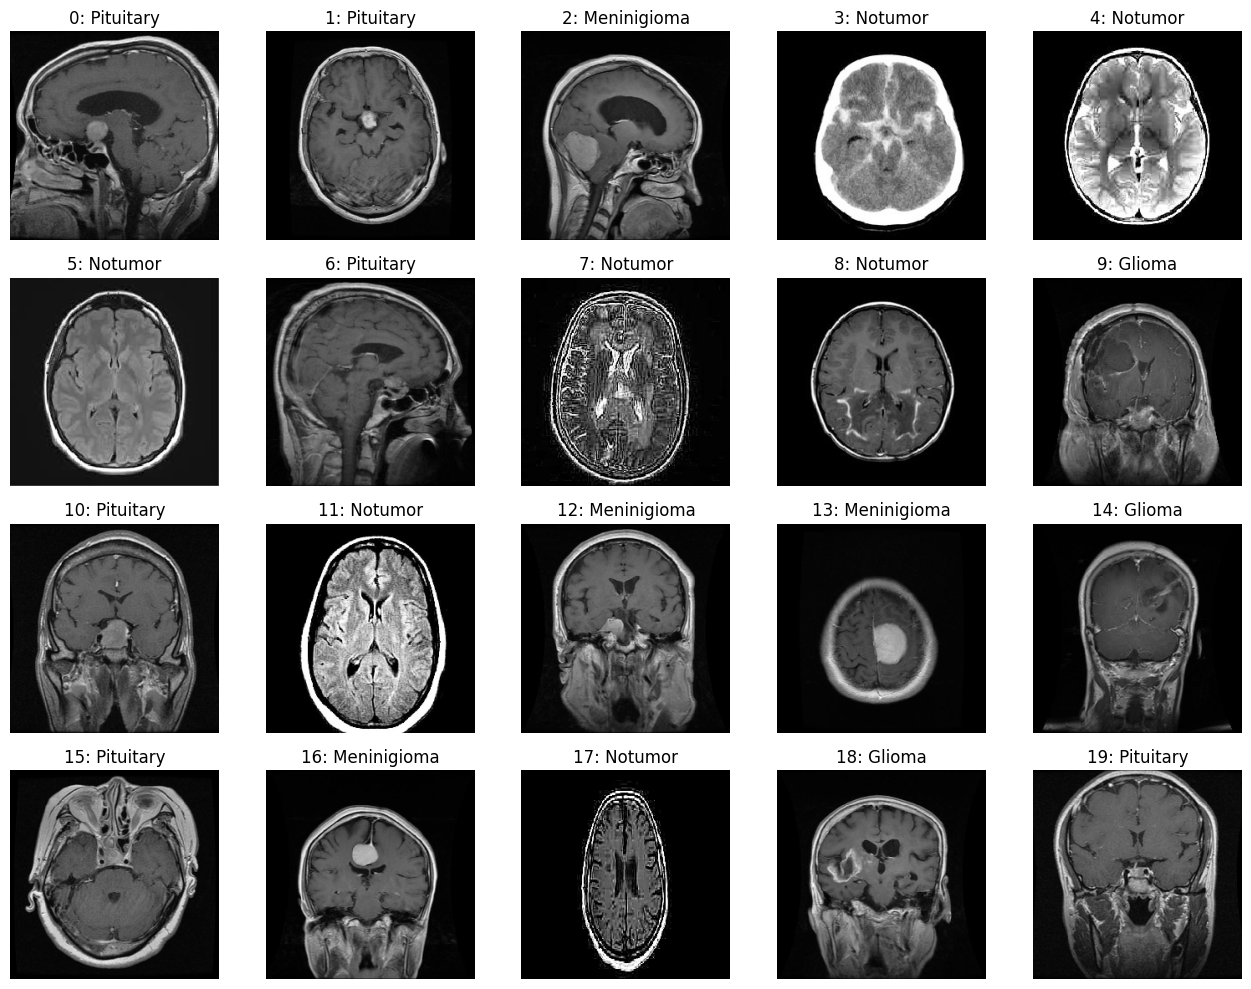

In [7]:
show_images(train_paths_sampled, train_index_sampled, class_mappings, im_size=250, figsize=(13,10),index_list=range(0, 20))

#### This function is to show how images are classified in both training and testing sets

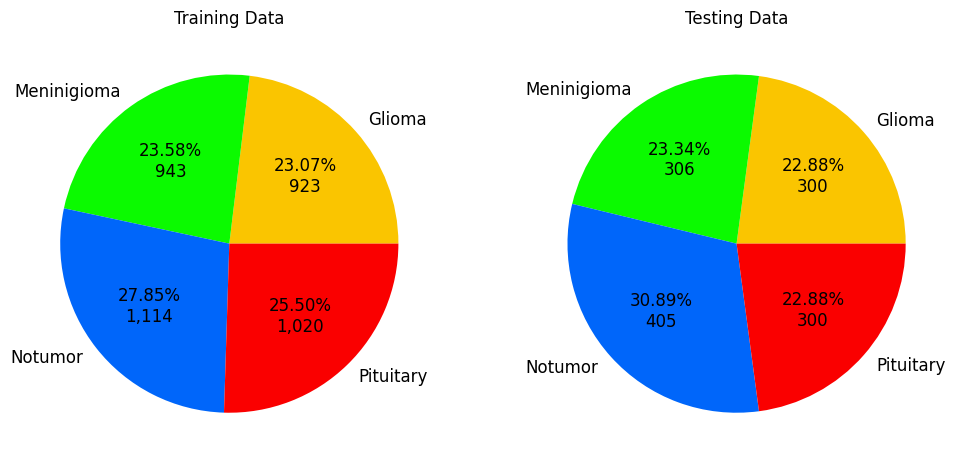

In [8]:
_, ax = plt.subplots(ncols=2, figsize=(12, 8))

class_counts = [len([x for x in train_index_sampled if x == label]) for label in set(train_index_sampled)]
ax[0].set_title('Training Data')
ax[0].pie(
    class_counts,
    labels=[label for label in class_names],
    colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    textprops={'fontsize': 12}
)

class_counts = [len([x for x in test_index if x == label]) for label in set(test_index)]
ax[1].set_title('Testing Data')
ax[1].pie(
    class_counts,
    labels=[label for label in class_names],
    colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    textprops={'fontsize': 12}
)

plt.show()

#### Sequential is used to define a linear stack of layers or a pipeline.
#### RandomRotation is used to rotate the images by a certain range of degrees during training.
#### RandomContrast is used to adjust the contrast of images randomly during training.
#### RandomZoom is used to apply random zoom-in or zoom-out transformations on the images.
#### RandomFlip is used to randomly flip the images horizontally, vertically, or both.
#### RandomTranslation is used to randomly shifting the image along the width and/or height axis.
#### Finally tf provides the TensorFlow library for deep learning, which includes Keras for model building, layer definitions, and training functionality.


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomContrast
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomTranslation
import tensorflow as tf

#### Here we preprocess the data we have 
#### In parse_function we decode the image data since at first it is in form of raw binary data our machine needs to decode it to process
#### By using this parse_function we PROCESS the image data and return the processed data in get_dataset 
#### It first combines paths and labels and create tensorflow dataset in path_ds as a tuple
#### After creating tuples in image_label_ds we called path_ds using lamda function which applies parse_function to each and every (path,label) tuple 
#### tf.data.autotune means it parallelizes the parse_funtion based on available hardware resources
#### then it returns the data after processing and resizing in batches and we store them in variables named train_ds and test_ds

In [10]:
def parse_function(filename, label, image_size, n_channels):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, n_channels)
    image = tf.image.resize(image, image_size)
    return image, label

def get_dataset(paths, labels, image_size, n_channels=1, num_classes=4, batch_size=32):
    path_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    image_label_ds = path_ds.map(lambda path, label: parse_function(path, label, image_size, n_channels), num_parallel_calls=tf.data.AUTOTUNE)
    return image_label_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

batch_size = 32
image_dim = (128, 128)
train_ds = get_dataset(train_paths_sampled, train_index_sampled , image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)

### Untill now we get training dataset and testing dataset both with a similar size and in batches 
#### Now we did an augmentation on training dataset with several layers below
#### And also normalized the pixels value of an image to increase efficiency of a model for both training and test data
#### And these are mapped into new variables

In [11]:
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

def preprocess_train(image, label):
    image = data_augmentation(image) / 255.0
    return image, label

def preprocess_test(image, label):
    return image / 255.0, label

train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

#### A function to display these augmented images

In [12]:
def plot_augmented_images(dataset, shape, class_mappings, figsize=(13, 10)):
    plt.figure(figsize=figsize)
    index_to_class = {v: k for k, v in class_mappings.items()}
    for images, label in dataset.take(1):
        i = 0
        for i in range(shape[0]*shape[1]):
            ax = plt.subplot(shape[0], shape[1], i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap='gray')
            plt.title(index_to_class[label.numpy()[i]])
            plt.axis("off")
            i += 1

    plt.tight_layout()
    plt.show()

#### Augmented images from training dataset 

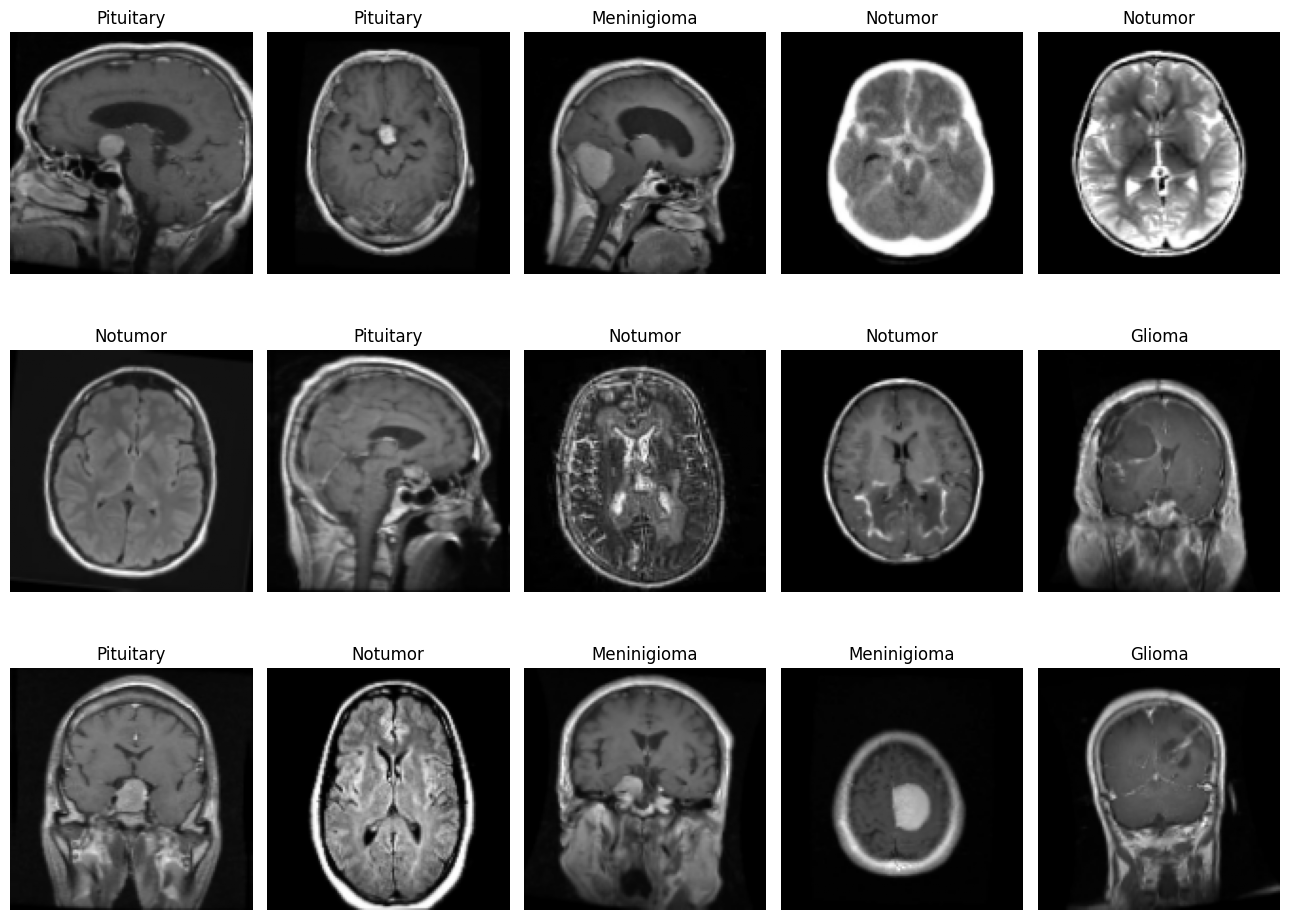

In [13]:
plot_augmented_images(train_ds_preprocessed, shape=(3, 5), class_mappings=class_mappings)

#### Here after Augmentation and Normalization on the images we apply one_hot encoding technique on labels of our data 
#### This makes our labels 0,1,2,3 as binary vectors [1,0,0,0],....,[0,0,0,1] 
#### This is used for multi class classification to calsify the image to a specific class through our model often using softmax activation funtion 

In [14]:
num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1)

epochs = 50
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)

Number of Classes: 4
Image shape: (128, 128, 1)
Epochs: 50
Batch size: 32


In [15]:
# Custom callback for reducing learning rate at accuracy values
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds  # List of accuracy thresholds
        self.factor = factor  # Factor to reduce the learning rate
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)  # Track each threshold

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True  # Mark this threshold as reached
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

# Try a custom callback
thresholds = [0.91, 0.94, 0.97]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.65, monitor='val_accuracy', verbose=False) 

In [16]:
image_height = 128
image_width = 128
channels = 1
num_classes = 4  

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(image_height, image_width, channels)),
    # First Convolutional Layer
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Second Convolutional Layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Third Convolutional Layer
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),

    # Fully Connected (Dense) Layers
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    # Output layer
    tf.keras.layers.Dense(num_classes, activation='softmax')  
])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       256       
 hNormalization)                                                 
                                                      

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor ='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

In [20]:
history = model.fit(
    train_ds_preprocessed,
    validation_data=test_ds_preprocessed,
    epochs=50,
    callbacks=[lr_callback,reduce_lr],   
    verbose=True
)

Epoch 1/50
125/125 [==============================] - 110s 803ms/step - loss: 1.0692 - accuracy: 0.7115 - val_loss: 22.1654 - val_accuracy: 0.2288 - lr: 5.0000e-04
Epoch 2/50
125/125 [==============================] - 94s 726ms/step - loss: 0.5477 - accuracy: 0.7952 - val_loss: 13.1745 - val_accuracy: 0.2311 - lr: 5.0000e-04
Epoch 3/50
125/125 [==============================] - 95s 733ms/step - loss: 0.4302 - accuracy: 0.8365 - val_loss: 1.0228 - val_accuracy: 0.6690 - lr: 5.0000e-04
Epoch 4/50
125/125 [==============================] - 94s 725ms/step - loss: 0.3696 - accuracy: 0.8645 - val_loss: 0.5930 - val_accuracy: 0.7681 - lr: 5.0000e-04
Epoch 5/50
125/125 [==============================] - 94s 719ms/step - loss: 0.3107 - accuracy: 0.8805 - val_loss: 0.3956 - val_accuracy: 0.8429 - lr: 5.0000e-04
Epoch 6/50
125/125 [==============================] - 92s 703ms/step - loss: 0.2820 - accuracy: 0.8870 - val_loss: 0.3603 - val_accuracy: 0.8680 - lr: 5.0000e-04
Epoch 7/50
125/125 [=====

In [21]:
test_loss, test_acc = model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")
print(f"Test loss: {test_loss*100:0.4f}%")

41/41 [==============================] - 7s 165ms/step - loss: 0.3132 - accuracy: 0.9375
Test accuracy: 93.7452%
Test loss: 31.3245%


In [24]:
from tensorflow.keras import backend as K
K.clear_session()

In [25]:
lstm_model = Sequential([
    tf.keras.layers.Input(shape=(128, 128, 1)),  

    # Reshape to (time_steps=128, features=128)
    tf.keras.layers.Reshape((128, 128)),

    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [26]:
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

history_lstm = lstm_model.fit(
    train_ds_preprocessed, 
    validation_data=test_ds_preprocessed,
    epochs=50,
    callbacks=[lr_callback, reduce_lr],
    verbose=True
)

Epoch 1/50
125/125 [==============================] - 85s 526ms/step - loss: 1.1872 - accuracy: 0.4845 - val_loss: 1.0363 - val_accuracy: 0.5622 - lr: 5.0000e-04
Epoch 2/50
125/125 [==============================] - 48s 372ms/step - loss: 0.9685 - accuracy: 0.6085 - val_loss: 0.9096 - val_accuracy: 0.6285 - lr: 5.0000e-04
Epoch 3/50
125/125 [==============================] - 46s 356ms/step - loss: 0.9024 - accuracy: 0.6482 - val_loss: 0.8839 - val_accuracy: 0.6430 - lr: 5.0000e-04
Epoch 4/50
125/125 [==============================] - 45s 348ms/step - loss: 0.8010 - accuracy: 0.6923 - val_loss: 0.7944 - val_accuracy: 0.6934 - lr: 5.0000e-04
Epoch 5/50
125/125 [==============================] - 44s 341ms/step - loss: 0.7913 - accuracy: 0.7057 - val_loss: 0.8852 - val_accuracy: 0.6461 - lr: 5.0000e-04
Epoch 6/50
125/125 [==============================] - 52s 404ms/step - loss: 0.7514 - accuracy: 0.7165 - val_loss: 0.8076 - val_accuracy: 0.6781 - lr: 5.0000e-04
Epoch 7/50
125/125 [========

In [27]:
test_loss_lstm, test_acc_lstm = lstm_model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc_lstm*100:0.4f}%")
print(f"Test loss: {test_loss_lstm*100:0.4f}%")

41/41 [==============================] - 12s 268ms/step - loss: 0.4720 - accuracy: 0.8307
Test accuracy: 83.0664%
Test loss: 47.2004%


In [29]:
from tensorflow.keras import layers, models

image_height = 128
image_width = 128
channels = 1
num_classes = 4

CNN_LSTM_model = models.Sequential([
    # CNN Layers
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(image_height, image_width, channels)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Reshape for LSTM: (batch, time_steps, features)
    layers.Reshape((16 * 16, 128)),

    # LSTM Layer
    layers.LSTM(64),

    # Final Dense Layers
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])


In [30]:
# Compile the model
CNN_LSTM_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Show model summary
CNN_LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                      

In [34]:
from tensorflow.keras import backend as K
K.clear_session()

In [35]:
CNN_LSTM_history = CNN_LSTM_model.fit(
    train_ds_preprocessed,
    validation_data=test_ds_preprocessed,
    epochs=50,
    callbacks=[lr_callback, reduce_lr],
    verbose=True
)

Epoch 1/50
125/125 [==============================] - 128s 979ms/step - loss: 0.9375 - accuracy: 0.6012 - val_loss: 1.6469 - val_accuracy: 0.2288 - lr: 5.0000e-04
Epoch 2/50
125/125 [==============================] - 107s 831ms/step - loss: 0.7861 - accuracy: 0.6743 - val_loss: 1.9229 - val_accuracy: 0.2304 - lr: 5.0000e-04
Epoch 3/50
125/125 [==============================] - 107s 827ms/step - loss: 0.7227 - accuracy: 0.7185 - val_loss: 1.8486 - val_accuracy: 0.2799 - lr: 5.0000e-04
Epoch 4/50
125/125 [==============================] - 108s 838ms/step - loss: 0.6505 - accuracy: 0.7458 - val_loss: 1.4415 - val_accuracy: 0.4477 - lr: 5.0000e-04
Epoch 5/50
125/125 [==============================] - 108s 842ms/step - loss: 0.5975 - accuracy: 0.7782 - val_loss: 1.2806 - val_accuracy: 0.5118 - lr: 5.0000e-04
Epoch 6/50
125/125 [==============================] - 107s 828ms/step - loss: 0.5760 - accuracy: 0.7795 - val_loss: 1.3257 - val_accuracy: 0.4966 - lr: 5.0000e-04
Epoch 7/50
125/125 [==

In [36]:
test_loss_cnn_lstm, test_acc_cnn_lstm = CNN_LSTM_model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc_cnn_lstm*100:0.4f}%")
print(f"Test loss: {test_loss_cnn_lstm*100:0.4f}%")

41/41 [==============================] - 24s 578ms/step - loss: 0.4972 - accuracy: 0.8497
Test accuracy: 84.9733%
Test loss: 49.7179%


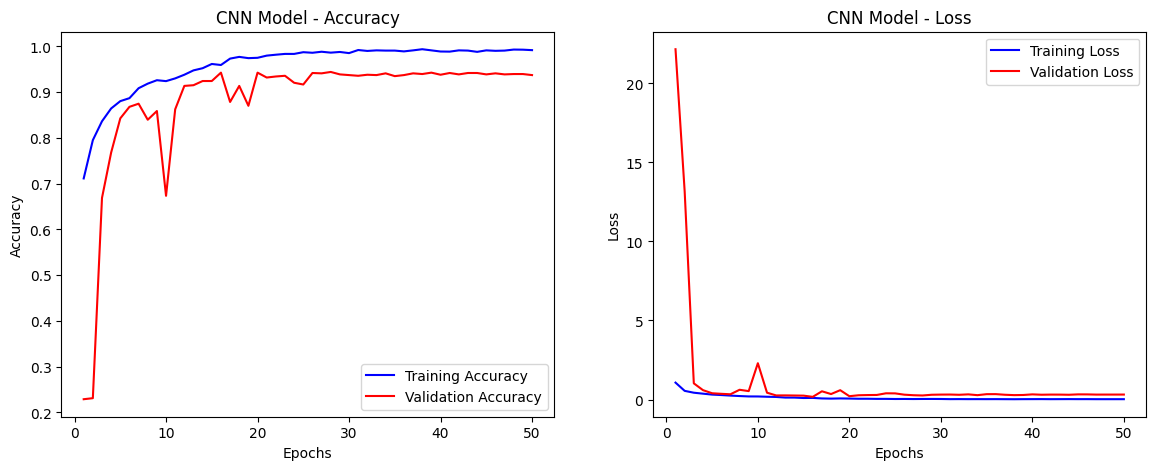

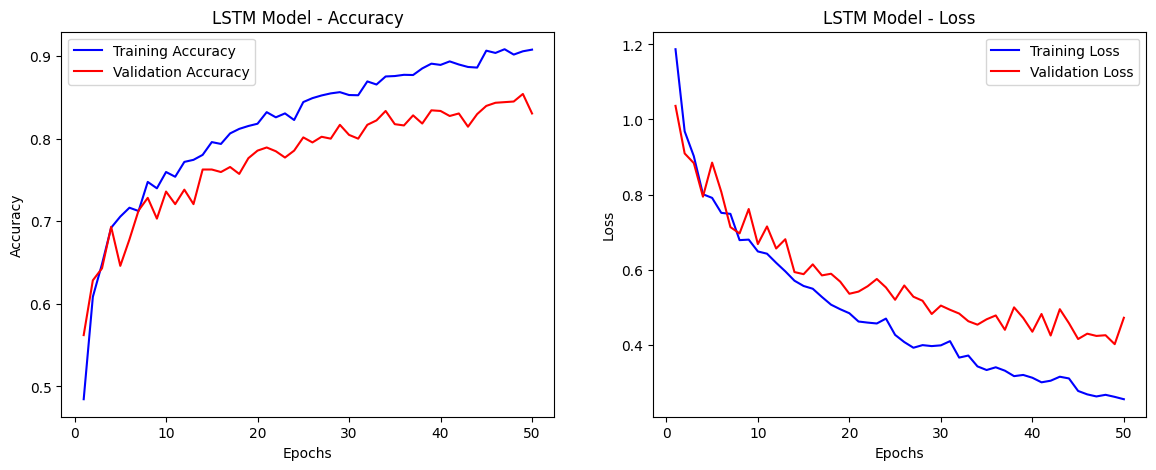

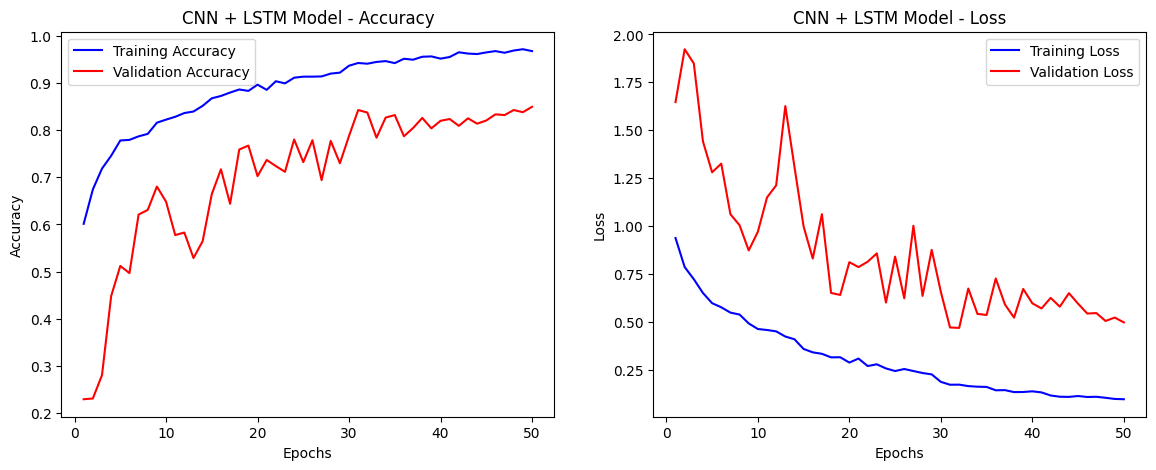

In [37]:
import matplotlib.pyplot as plt

def plot_training_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14,5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Example usage
plot_training_history(history, "CNN Model")
plot_training_history(history_lstm, "LSTM Model")
plot_training_history(CNN_LSTM_history, "CNN + LSTM Model")

Grad-CAM for CNN model:


C:\Users\nanda\AppData\Local\Temp\ipykernel_6068\34852815.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


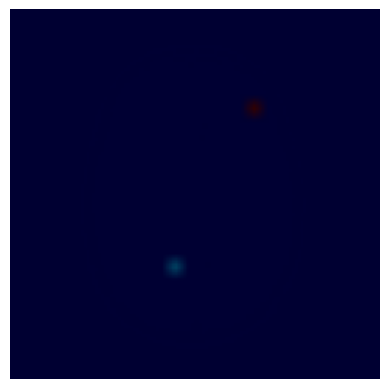

Grad-CAM for CNN+LSTM model:


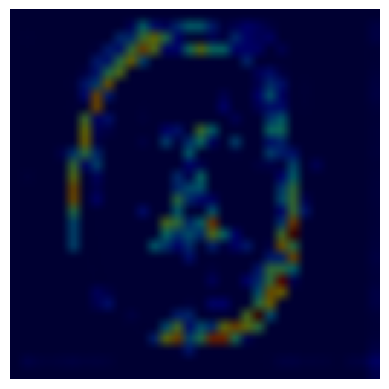


Grad-CAM cannot be generated for pure LSTM models (no Conv layers) ❌.


In [43]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.cm as cm

# Grad-CAM Function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations of the last conv layer + output
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for the input image
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Get the gradients of the class output value with respect to the feature map
    grads = tape.gradient(class_channel, conv_outputs)

    # Pool the gradients over all axes
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the feature maps by the pooled gradients
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Plot function
def display_gradcam(image, heatmap, alpha=0.4):
    # Ensure input image is numpy array
    if not isinstance(image, np.ndarray):
        image = np.array(image)

    # If grayscale, expand to 3 channels
    if len(image.shape) == 2:   
        image = np.stack([image, image, image], axis=-1)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Apply jet colormap to heatmap
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = np.uint8(jet_heatmap * 255)

    # Resize heatmap to match image size
    jet_heatmap = tf.image.resize(jet_heatmap, (image.shape[0], image.shape[1])).numpy()

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + image
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    # Display image
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()


# -----------------------------------
# 📸 Example usage for your models
# -----------------------------------

# Prepare a batch of test images (just take one image)
sample_image, sample_label = next(iter(test_ds_preprocessed))
sample_image = sample_image[0]  # Take first image
sample_label = sample_label[0]

# Expand dimensions to make it (1, 128, 128, 1)
sample_image_expanded = np.expand_dims(sample_image, axis=0)

# ----------------------------
# 1. For CNN model
# ----------------------------
last_conv_layer_name_cnn = "conv2d_2"  # You can check model.summary() to confirm last conv layer name
heatmap_cnn = make_gradcam_heatmap(sample_image_expanded, model, last_conv_layer_name_cnn)

print("Grad-CAM for CNN model:")
display_gradcam(np.squeeze(sample_image.numpy()), heatmap_cnn)

# ----------------------------
# 2. For CNN+LSTM model
# ----------------------------
last_conv_layer_name_cnnlstm = "conv2d_2"  # Check CNN_LSTM_model.summary() for correct layer name
heatmap_cnnlstm = make_gradcam_heatmap(sample_image_expanded, CNN_LSTM_model, last_conv_layer_name_cnnlstm)

print("Grad-CAM for CNN+LSTM model:")
display_gradcam(np.squeeze(sample_image.numpy()), heatmap_cnnlstm)

# ----------------------------
# 3. For LSTM model
# ----------------------------
print("\nGrad-CAM cannot be generated for pure LSTM models (no Conv layers) ❌.")


41/41 [==============================] - 11s 233ms/step


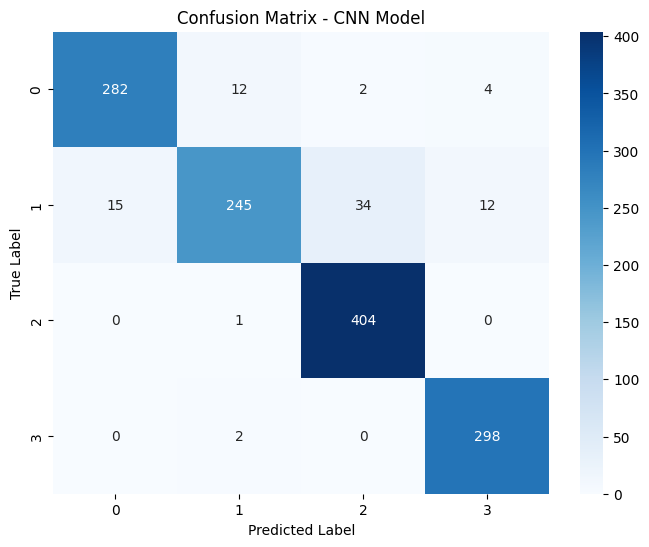

Classification Report for CNN Model:

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       300
           1       0.94      0.80      0.87       306
           2       0.92      1.00      0.96       405
           3       0.95      0.99      0.97       300

    accuracy                           0.94      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.94      0.94      0.94      1311



41/41 [==============================] - 15s 236ms/step


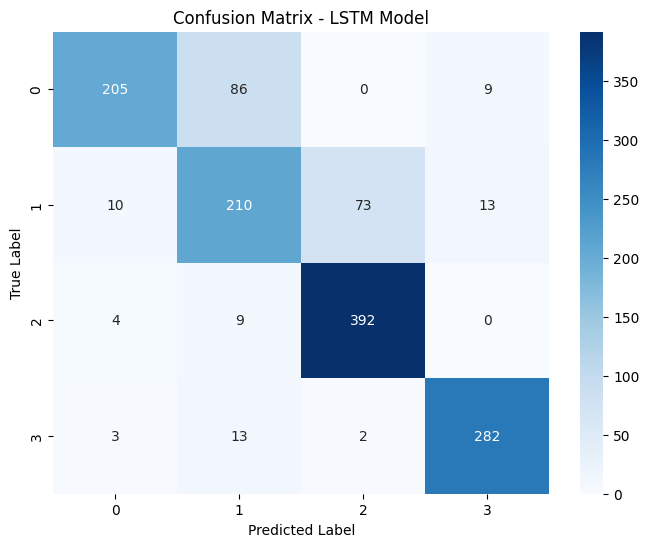

Classification Report for LSTM Model:

              precision    recall  f1-score   support

           0       0.92      0.68      0.79       300
           1       0.66      0.69      0.67       306
           2       0.84      0.97      0.90       405
           3       0.93      0.94      0.93       300

    accuracy                           0.83      1311
   macro avg       0.84      0.82      0.82      1311
weighted avg       0.84      0.83      0.83      1311



41/41 [==============================] - 14s 265ms/step


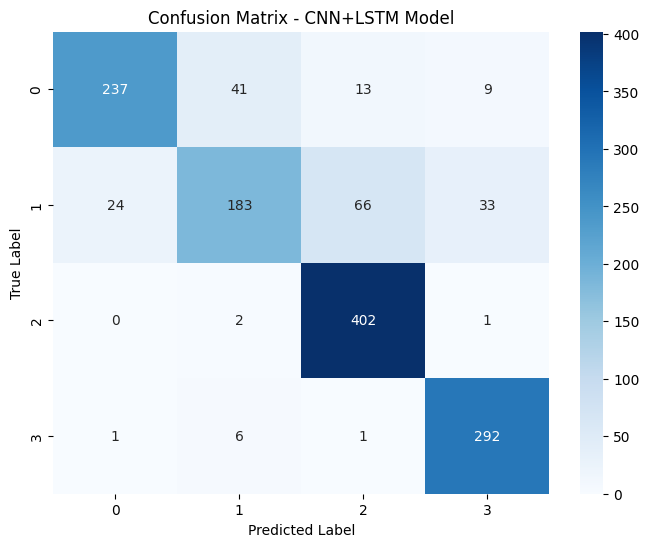

Classification Report for CNN+LSTM Model:

              precision    recall  f1-score   support

           0       0.90      0.79      0.84       300
           1       0.79      0.60      0.68       306
           2       0.83      0.99      0.91       405
           3       0.87      0.97      0.92       300

    accuracy                           0.85      1311
   macro avg       0.85      0.84      0.84      1311
weighted avg       0.85      0.85      0.84      1311





In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Create a reusable function
def plot_confusion_matrix(model, test_ds, model_name="Model"):
    # Step 1: Get true labels
    y_true = np.concatenate([y for x, y in test_ds], axis=0)

    # Step 2: Predict
    y_pred = model.predict(test_ds)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)

    # Step 3: Create confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # Step 4: Plot
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Step 5: Print Precision, Recall, F1-Score
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_true_classes, y_pred_classes))
    print("\n" + "="*60 + "\n")

# For CNN model
plot_confusion_matrix(model, test_ds_preprocessed, "CNN Model")

# For LSTM model
plot_confusion_matrix(lstm_model, test_ds_preprocessed, "LSTM Model")

# For CNN+LSTM model
plot_confusion_matrix(CNN_LSTM_model, test_ds_preprocessed, "CNN+LSTM Model")


In [44]:
print("Normal labels (before one-hot encoding):")
print(train_index_sampled[:10])  # Show first 10 labels

Normal labels (before one-hot encoding):
[3, 3, 1, 2, 2, 2, 3, 2, 2, 0]


In [45]:
# Take a batch from preprocessed train_ds
for images, labels in train_ds_preprocessed.take(1):
    print("One-hot encoded labels:")
    print(labels.numpy()[:10])  # Show first 10 labels

One-hot encoded labels:
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]


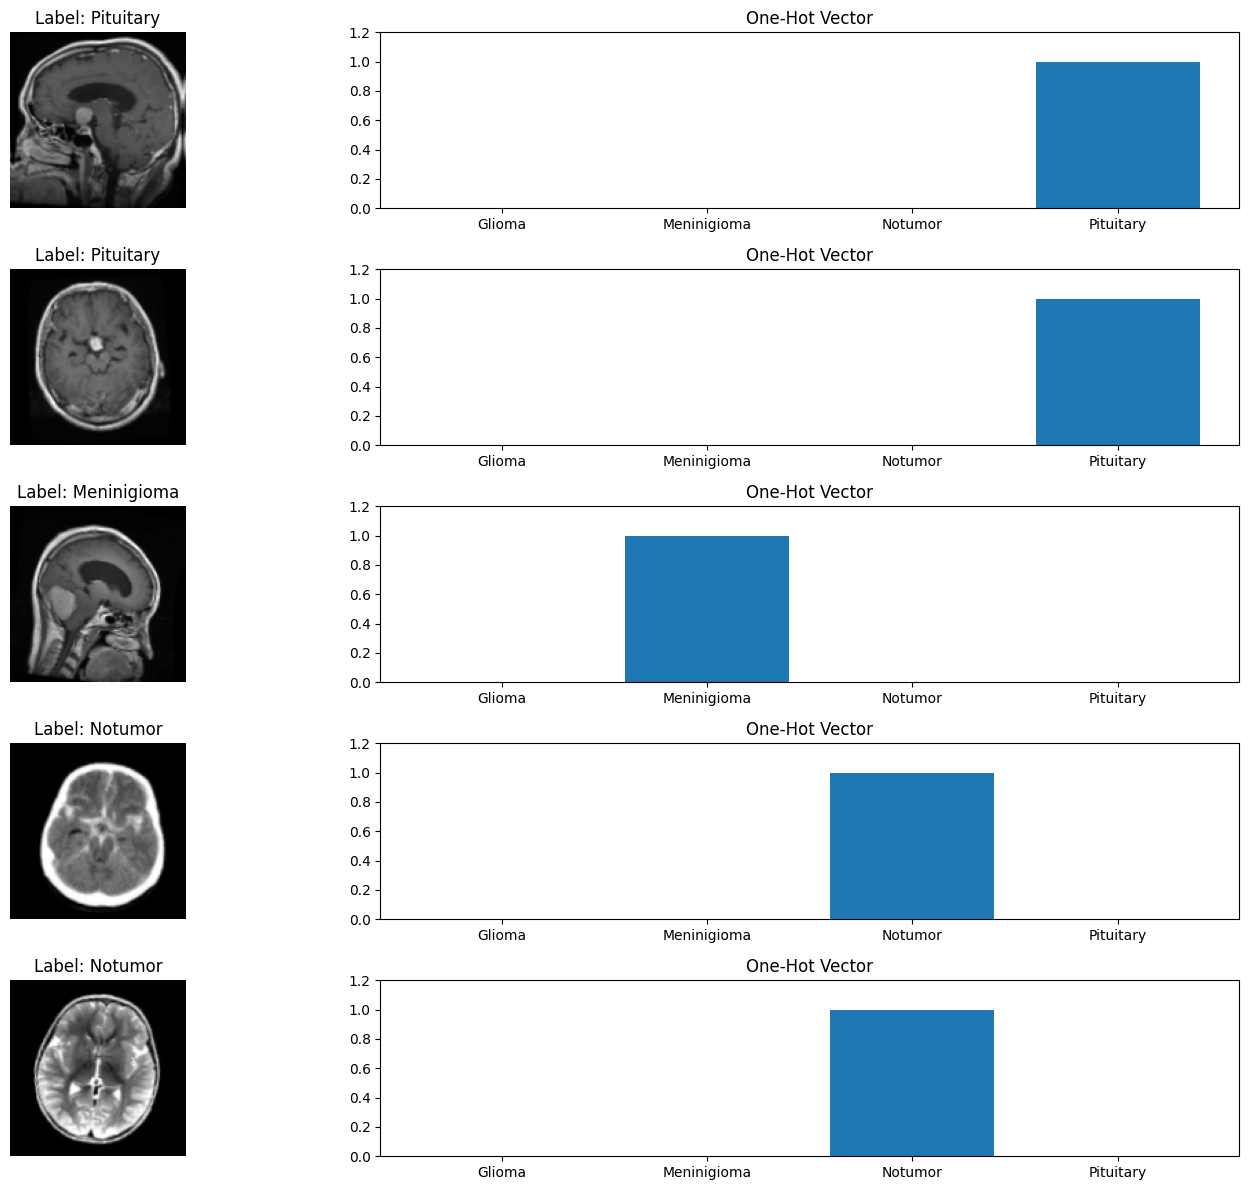

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Take one batch
for images, labels in train_ds_preprocessed.take(1):
    one_hot_labels = labels.numpy()

# Decode one-hot to normal labels
normal_labels = np.argmax(one_hot_labels, axis=1)

# Let's pick first 5 samples
fig, axs = plt.subplots(5, 2, figsize=(16, 12))

for i in range(5):
    # Original Image
    axs[i, 0].imshow(tf.squeeze(images[i]), cmap='gray')
    axs[i, 0].axis('off')
    label_name = class_names[normal_labels[i]]  
    axs[i, 0].set_title(f"Label: {label_name}")

    # One-hot Label
    axs[i, 1].bar(range(num_classes), one_hot_labels[i])
    axs[i, 1].set_xticks(range(num_classes))
    axs[i, 1].set_xticklabels(class_names)
    axs[i, 1].set_ylim(0, 1.2)
    axs[i, 1].set_title("One-Hot Vector")

plt.tight_layout()
plt.show()


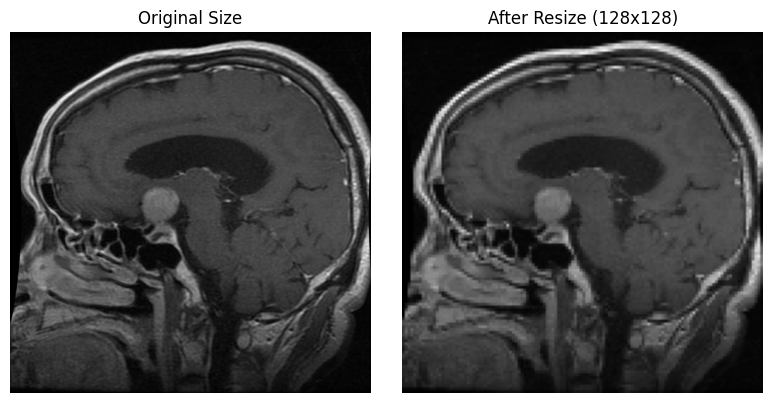

In [52]:
# Original Image (before resize)
original_image_path = train_paths_sampled[0]
original_image = tf.io.read_file(original_image_path)
original_image = tf.image.decode_jpeg(original_image, channels=1)

# Resize to (128, 128)
resized_image = tf.image.resize(original_image, [128, 128])

# Plot Original vs Resized
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(tf.squeeze(original_image), cmap='gray')
plt.title('Original Size')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(tf.squeeze(resized_image), cmap='gray')
plt.title('After Resize (128x128)')
plt.axis('off')

plt.tight_layout()
plt.show()


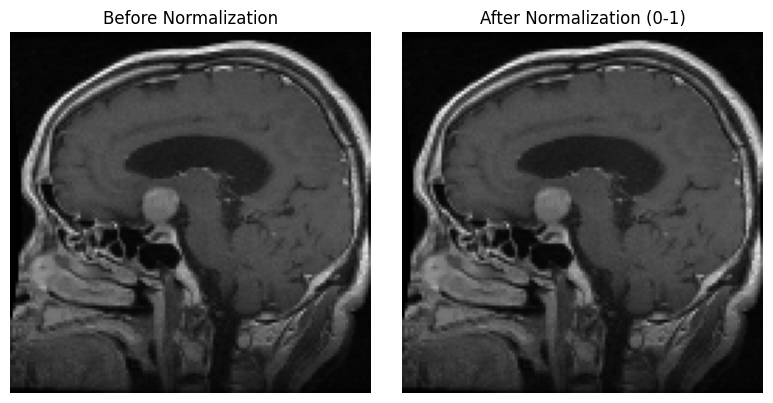

In [53]:
# Resize first (because normalization is usually done after resize)
resized_image = tf.image.resize(original_image, [128, 128])

# Apply Normalization (pixel values from 0-255 → 0-1)
normalized_image = resized_image / 255.0

# Plot Before Normalization vs After Normalization
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(tf.squeeze(resized_image), cmap='gray')
plt.title('Before Normalization')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(tf.squeeze(normalized_image), cmap='gray')
plt.title('After Normalization (0-1)')
plt.axis('off')

plt.tight_layout()
plt.show()


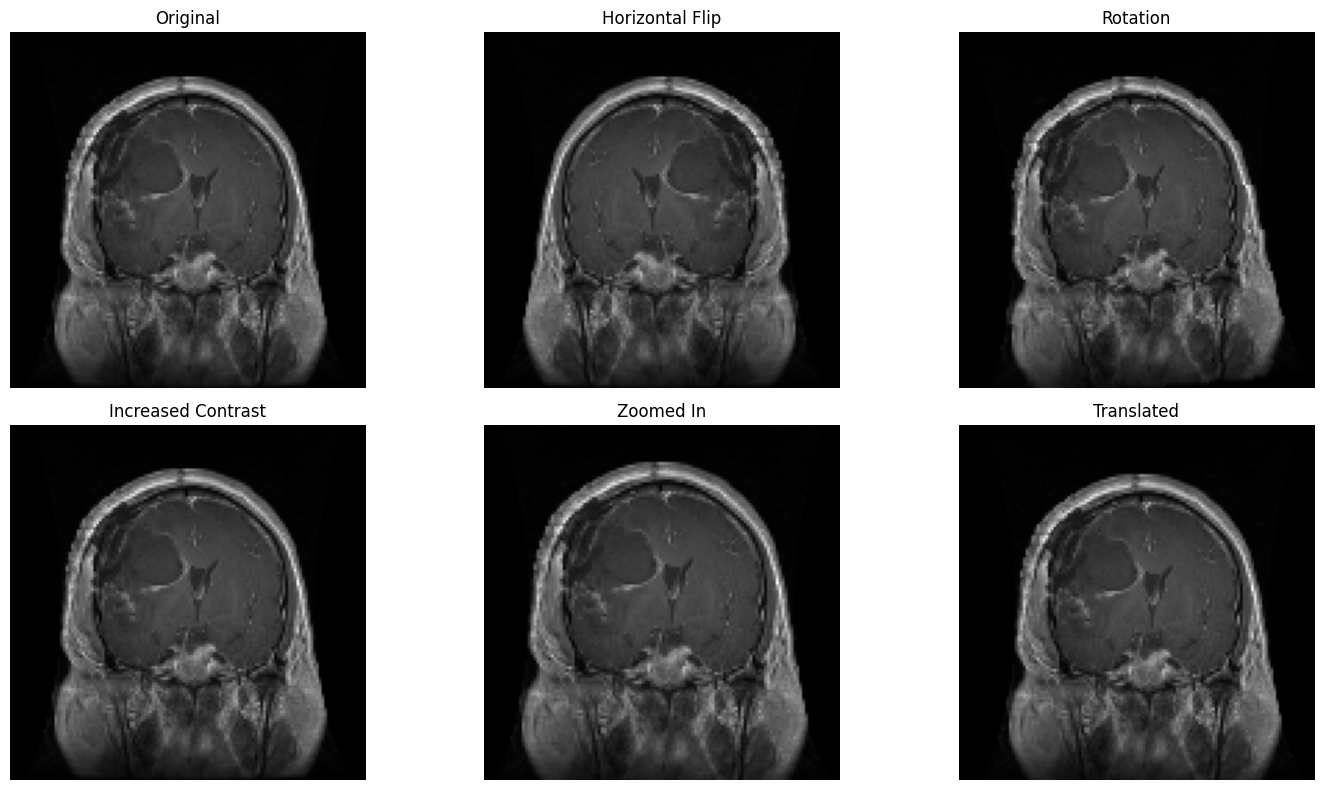

In [57]:
import tensorflow_addons as tfa

# Pick one sample image
original_image_path = train_paths_sampled[9]
original_image = tf.io.read_file(original_image_path)
original_image = tf.image.decode_jpeg(original_image, channels=1)
original_image = tf.image.resize(original_image, [128, 128])

# Apply each augmentation separately
flipped_image = tf.image.flip_left_right(original_image)
rotated_image = tfa.image.rotate(original_image, 0.02 * 3.1416)  # 0.02 radians ≈ 1 degree
contrast_image = tf.image.adjust_contrast(original_image, 1.1)
zoomed_image = tf.image.central_crop(original_image, central_fraction=0.95)
translated_image = tfa.image.translate(original_image, [2, 2])

# Plot all images
plt.figure(figsize=(15, 8))

# 1. Original
plt.subplot(2, 3, 1)
plt.imshow(tf.squeeze(original_image), cmap='gray')
plt.title('Original')
plt.axis('off')

# 2. Flipped
plt.subplot(2, 3, 2)
plt.imshow(tf.squeeze(flipped_image), cmap='gray')
plt.title('Horizontal Flip')
plt.axis('off')

# 3. Rotated
plt.subplot(2, 3, 3)
plt.imshow(tf.squeeze(rotated_image), cmap='gray')
plt.title('Rotation')
plt.axis('off')

# 4. Contrast Adjusted
plt.subplot(2, 3, 4)
plt.imshow(tf.squeeze(contrast_image), cmap='gray')
plt.title('Increased Contrast')
plt.axis('off')

# 5. Zoomed
plt.subplot(2, 3, 5)
plt.imshow(tf.squeeze(zoomed_image), cmap='gray')
plt.title('Zoomed In')
plt.axis('off')

# 6. Translated
plt.subplot(2, 3, 6)
plt.imshow(tf.squeeze(translated_image), cmap='gray')
plt.title('Translated')
plt.axis('off')

plt.tight_layout()
plt.show()


In [67]:
# Example for CNN model
y_pred_probs_cnn = model.predict(test_ds_preprocessed)

# Example for CNN+LSTM model
y_pred_probs_cnnlstm = CNN_LSTM_model.predict(test_ds_preprocessed)

# Example for LSTM model
y_pred_probs_lstm = lstm_model.predict(test_ds_preprocessed)


41/41 [==============================] - 3s 63ms/step


In [71]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


In [76]:
# Binarize the true labels
y_true_binarized = label_binarize(test_index, classes=[0, 1, 2, 3])


In [77]:
def plot_roc_curves(y_true_binarized, y_pred_probs, model_name, class_names):
    plt.figure(figsize=(10, 8))

    colors = ['blue', 'red', 'green', 'purple']  # Different color per class

    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i], lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='black', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


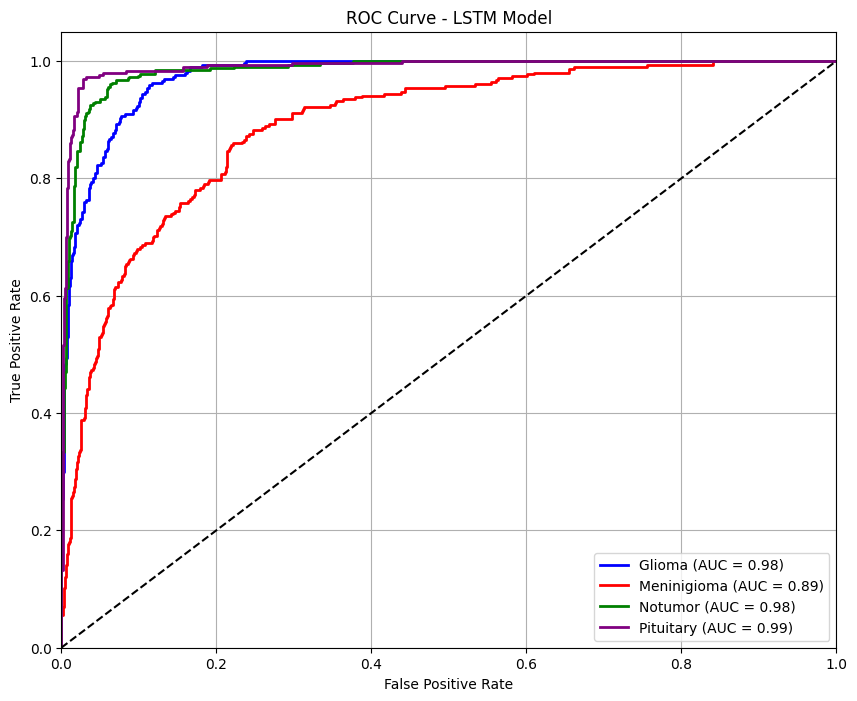

In [78]:
plot_roc_curves(y_true_binarized, y_pred_probs_lstm, "LSTM Model", class_names)


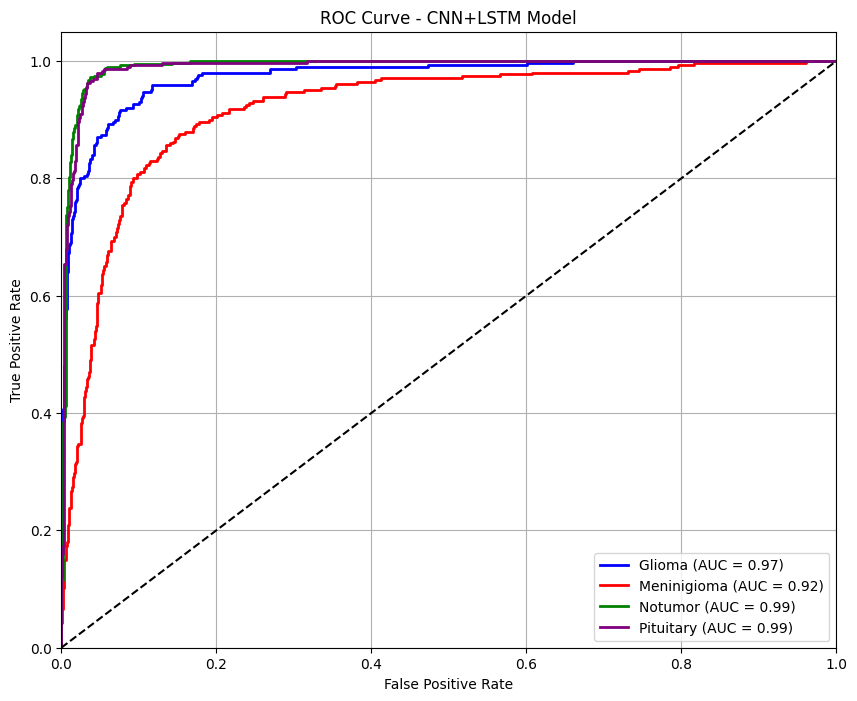

In [79]:
plot_roc_curves(y_true_binarized, y_pred_probs_cnnlstm, "CNN+LSTM Model", class_names)


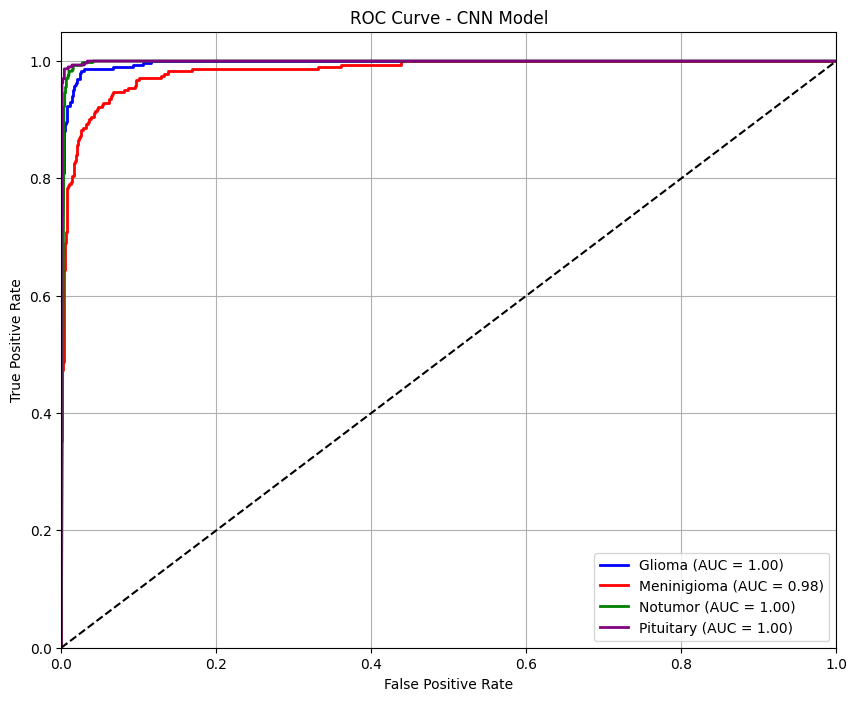

In [80]:
plot_roc_curves(y_true_binarized, y_pred_probs_cnn, "CNN Model", class_names)


In [81]:
import numpy as np

def get_correct_wrong_preds(y_pred_probs, y_true):
    correct_preds = []
    wrong_preds = []

    for idx in range(len(y_true)):
        true_label = y_true[idx]
        pred_label = np.argmax(y_pred_probs[idx])  # Get highest probability class

        if pred_label == true_label:
            correct_preds.append((test_paths[idx], true_label, pred_label))
        else:
            wrong_preds.append((test_paths[idx], true_label, pred_label))

    print(f"✅ Correct: {len(correct_preds)} | ❌ Wrong: {len(wrong_preds)}")
    return correct_preds, wrong_preds

# Get correct & wrong predictions for each model
correct_cnn, wrong_cnn = get_correct_wrong_preds(y_pred_probs_cnn, test_index)
correct_cnnlstm, wrong_cnnlstm = get_correct_wrong_preds(y_pred_probs_cnnlstm, test_index)
correct_lstm, wrong_lstm = get_correct_wrong_preds(y_pred_probs_lstm, test_index)


✅ Correct: 1229 | ❌ Wrong: 82
✅ Correct: 1114 | ❌ Wrong: 197
✅ Correct: 1089 | ❌ Wrong: 222


In [82]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to decode and visualize images
def visualize_predictions(pred_list, title, num_samples=8):
    plt.figure(figsize=(16, 10))
    sample_preds = pred_list[:num_samples]  # Take first few samples

    for i, (image_path, true_label, pred_label) in enumerate(sample_preds):
        image_string = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image_string, channels=1)
        image = tf.image.resize(image, (128, 128))
        image = tf.squeeze(image)  # Remove extra dimensions

        color = "green" if true_label == pred_label else "red"
        plt.subplot(2, 4, i + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.title(f"True: {index_to_class[true_label]}\nPred: {index_to_class[pred_label]}", 
                  fontsize=10, color=color)

    plt.suptitle(title, fontsize=16, color=color)
    plt.tight_layout()
    plt.show()


C:\Users\nanda\AppData\Local\Temp\ipykernel_6068\3626702476.py:23: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\nanda\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


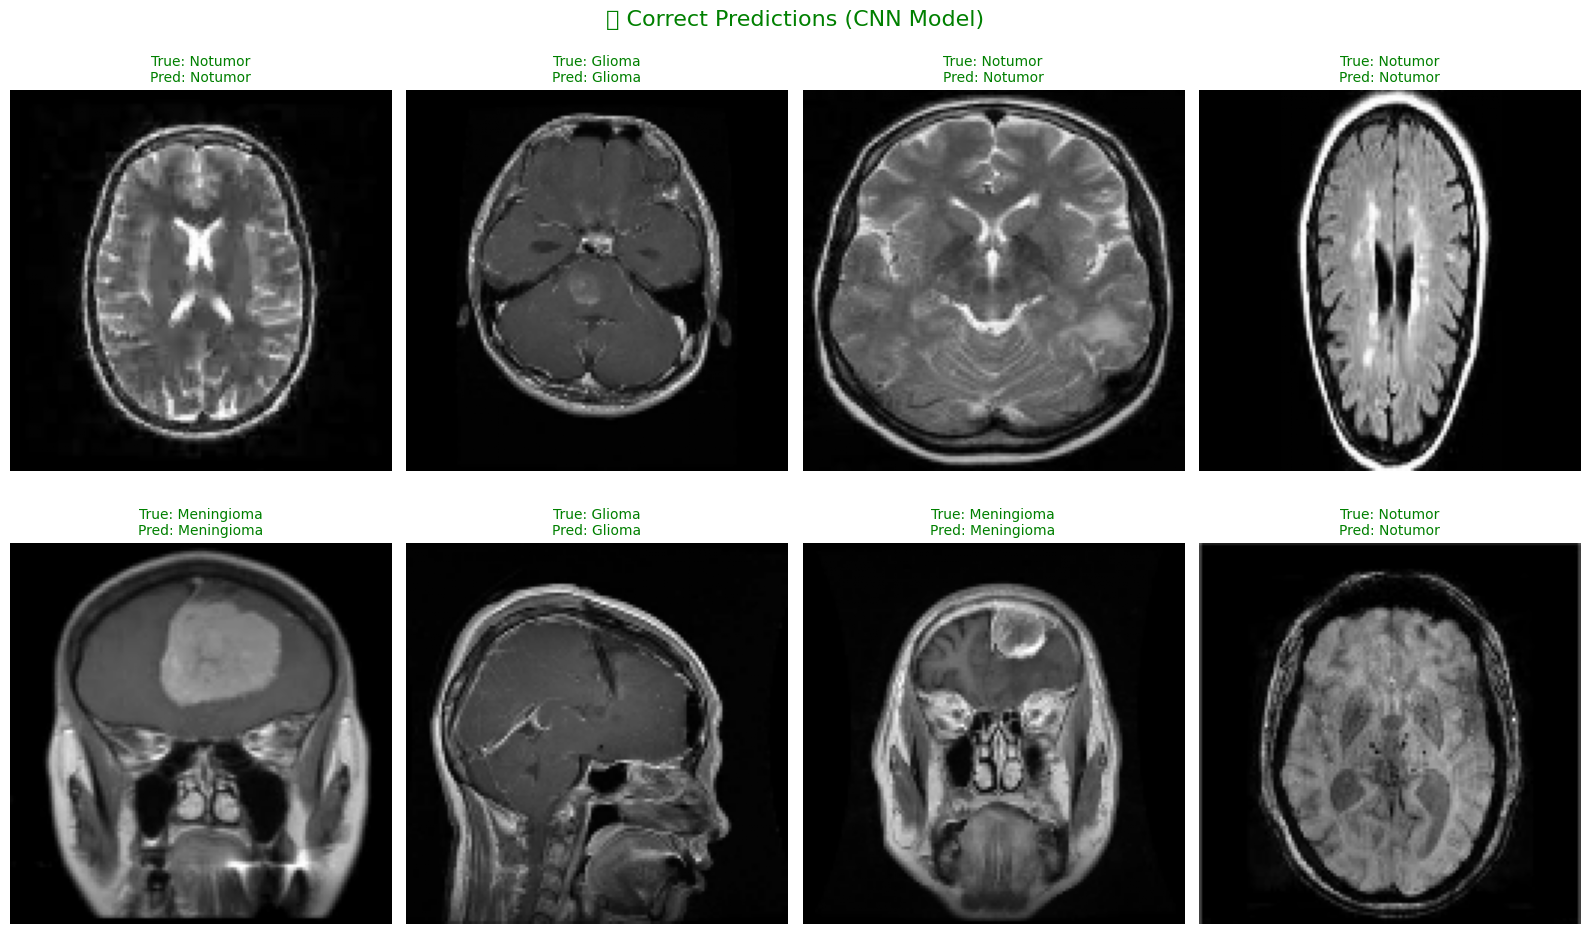

C:\Users\nanda\AppData\Local\Temp\ipykernel_6068\3626702476.py:23: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\nanda\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


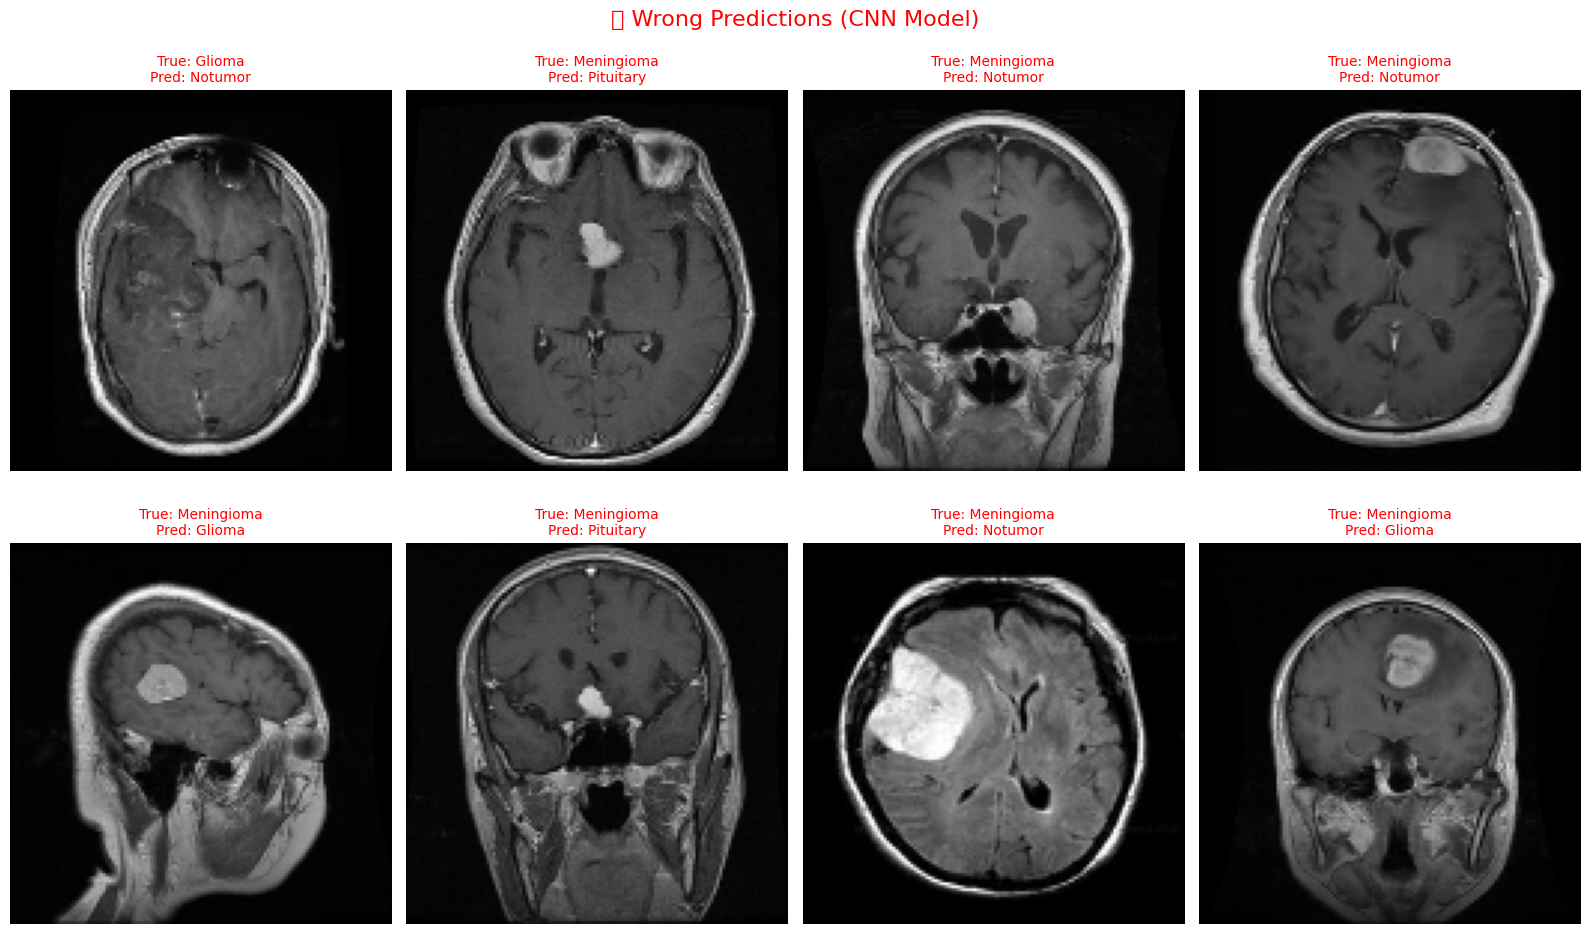

In [83]:
visualize_predictions(correct_cnn, "✅ Correct Predictions (CNN Model)")
visualize_predictions(wrong_cnn, "❌ Wrong Predictions (CNN Model)")


C:\Users\nanda\AppData\Local\Temp\ipykernel_6068\3626702476.py:23: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


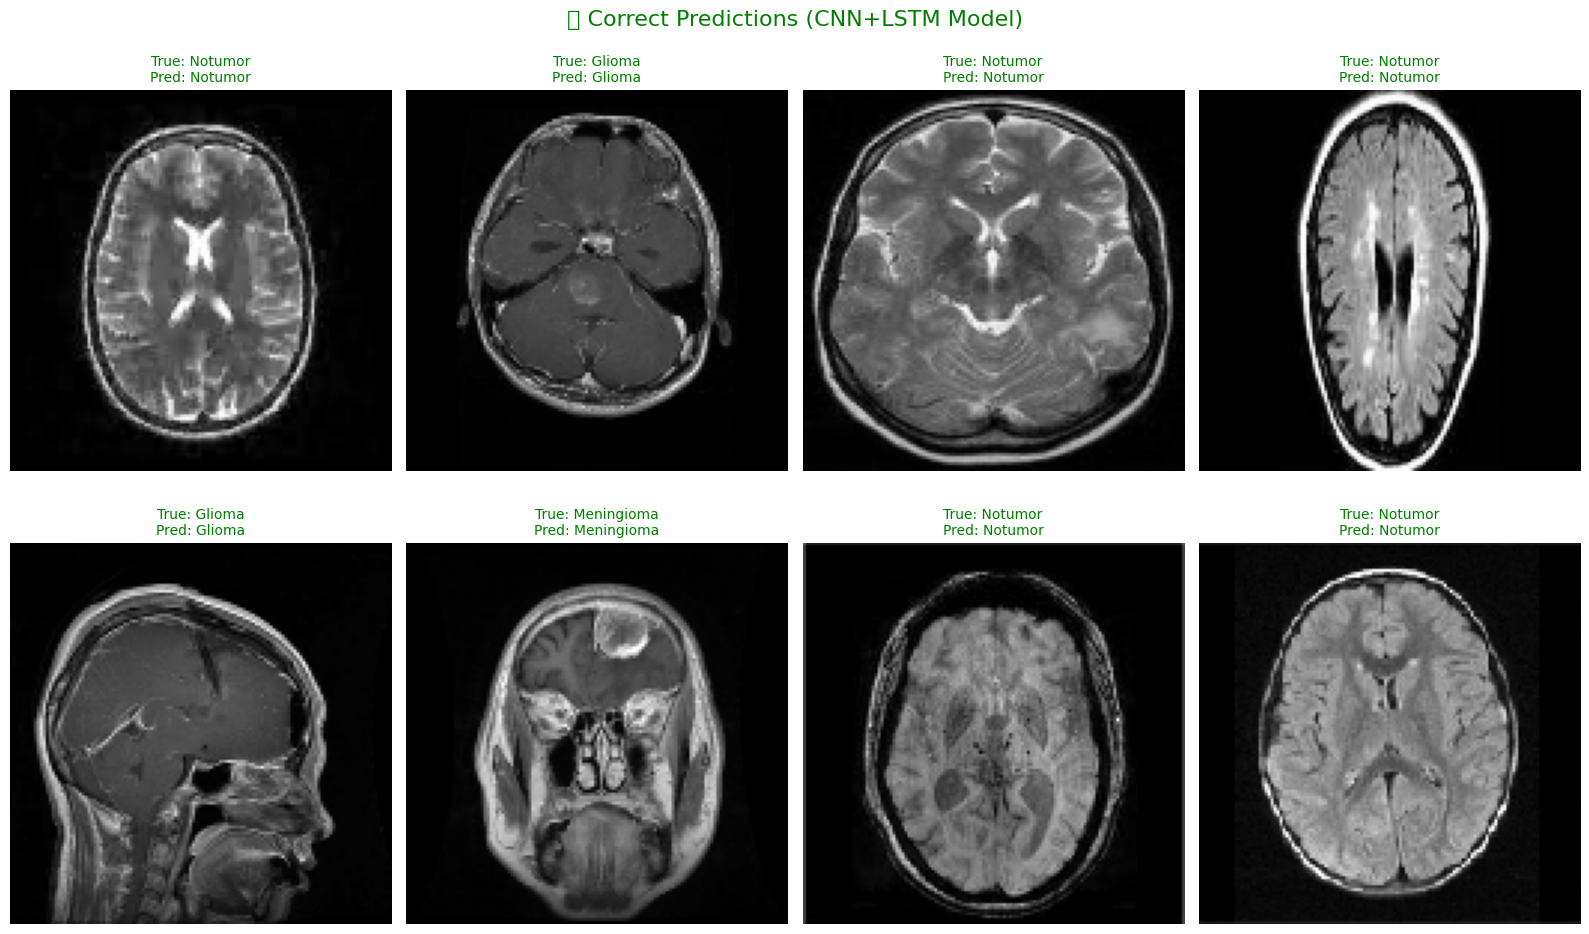

C:\Users\nanda\AppData\Local\Temp\ipykernel_6068\3626702476.py:23: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


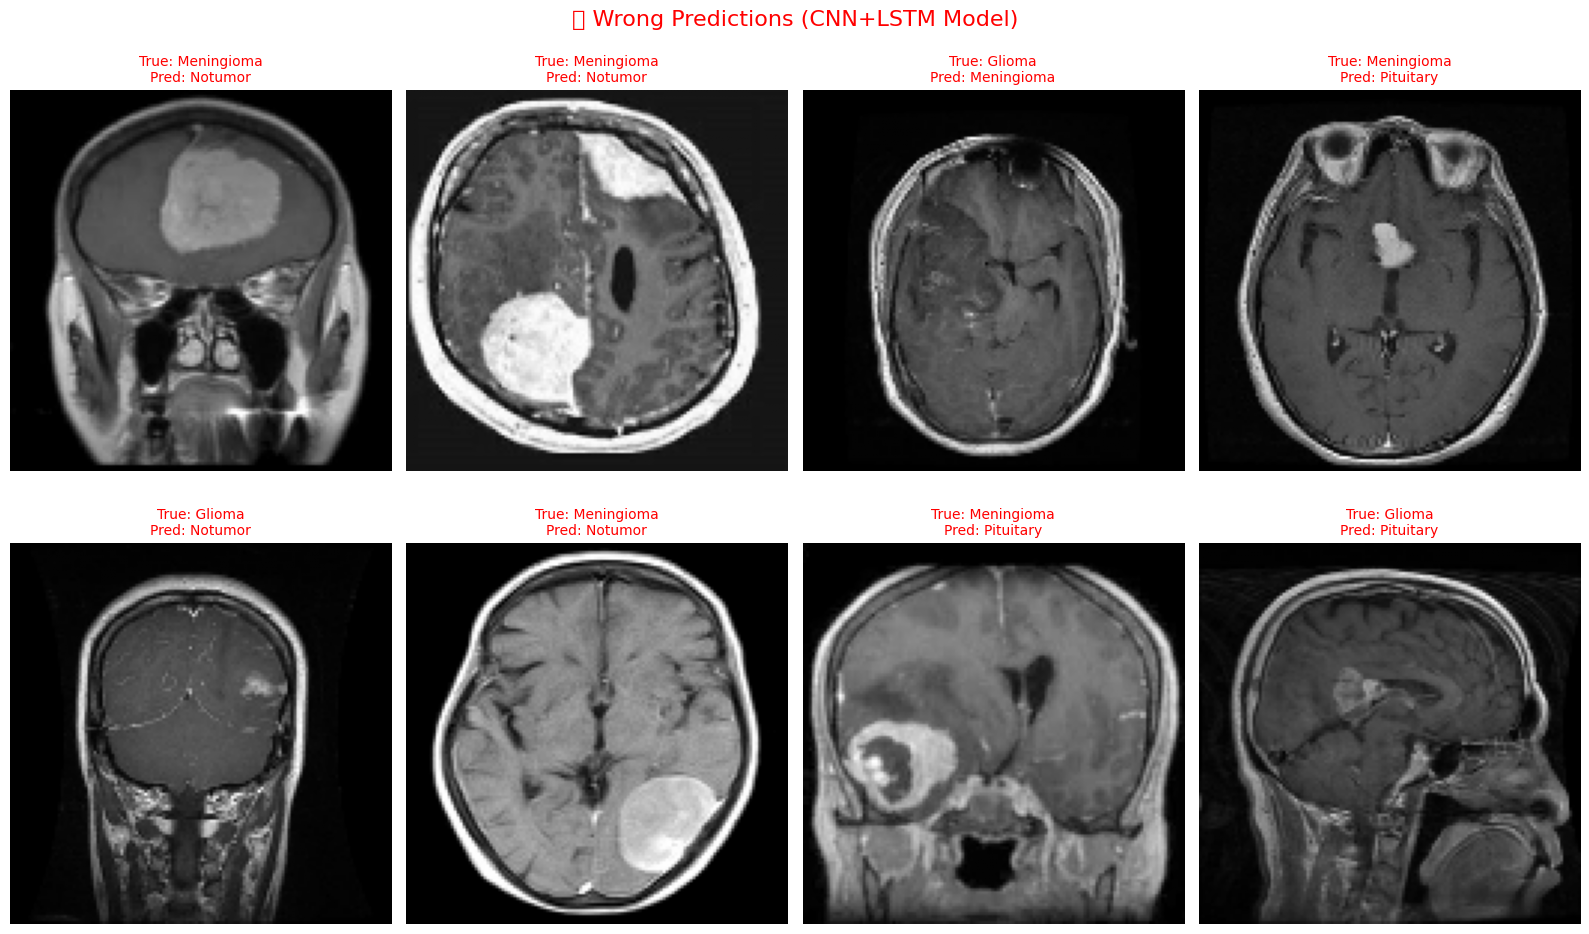

In [84]:
visualize_predictions(correct_cnnlstm, "✅ Correct Predictions (CNN+LSTM Model)")
visualize_predictions(wrong_cnnlstm, "❌ Wrong Predictions (CNN+LSTM Model)")


C:\Users\nanda\AppData\Local\Temp\ipykernel_6068\3626702476.py:23: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


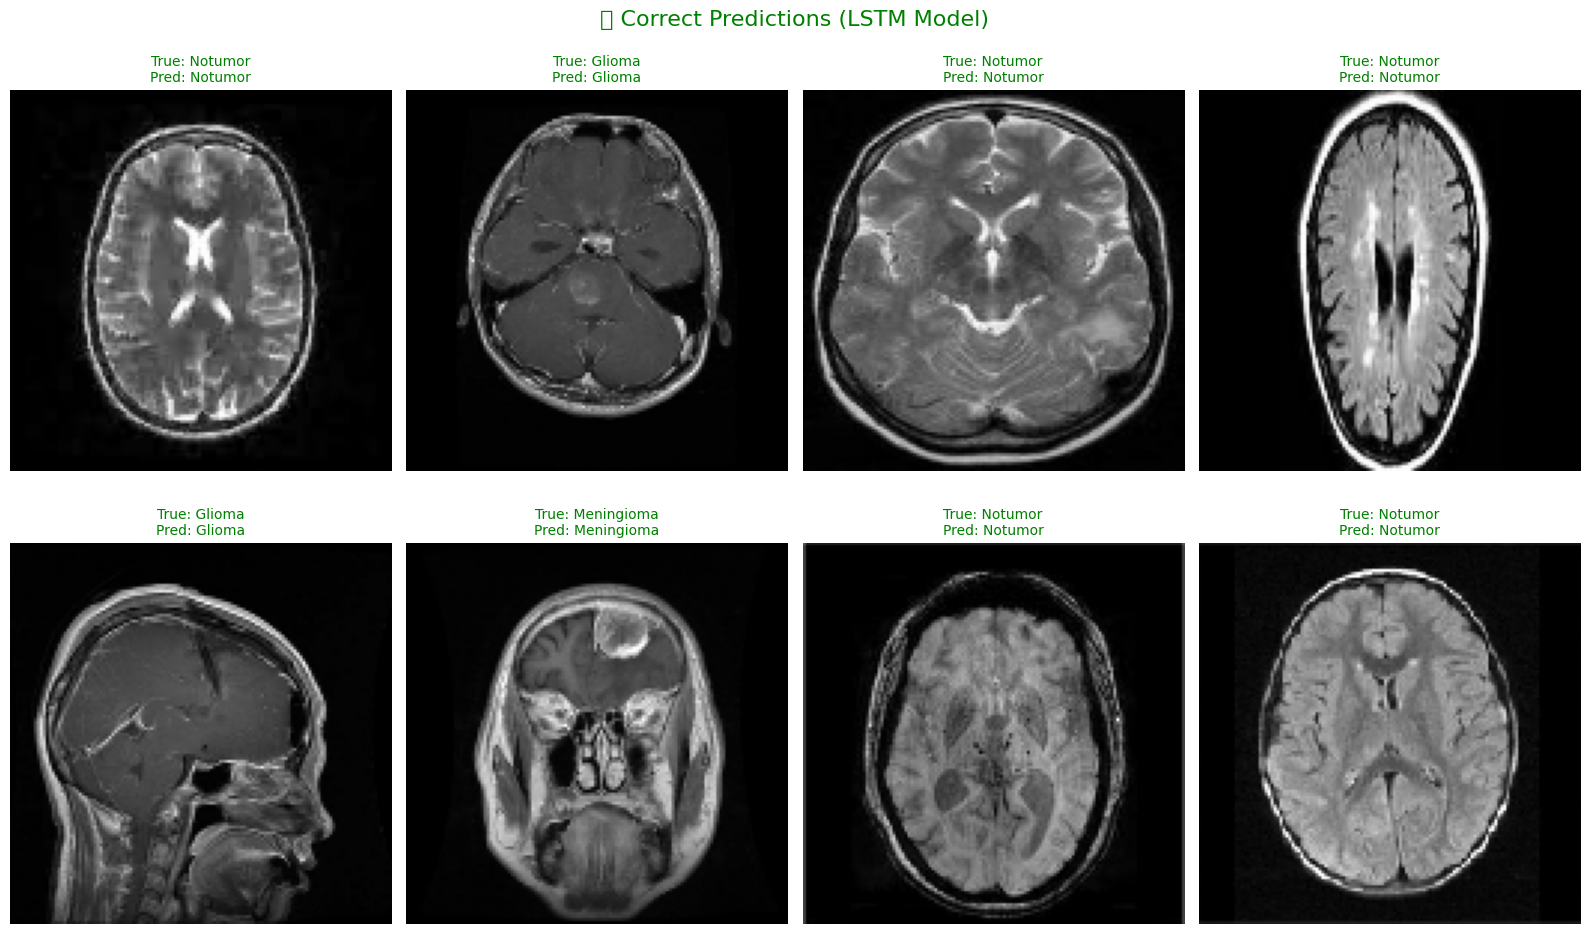

C:\Users\nanda\AppData\Local\Temp\ipykernel_6068\3626702476.py:23: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


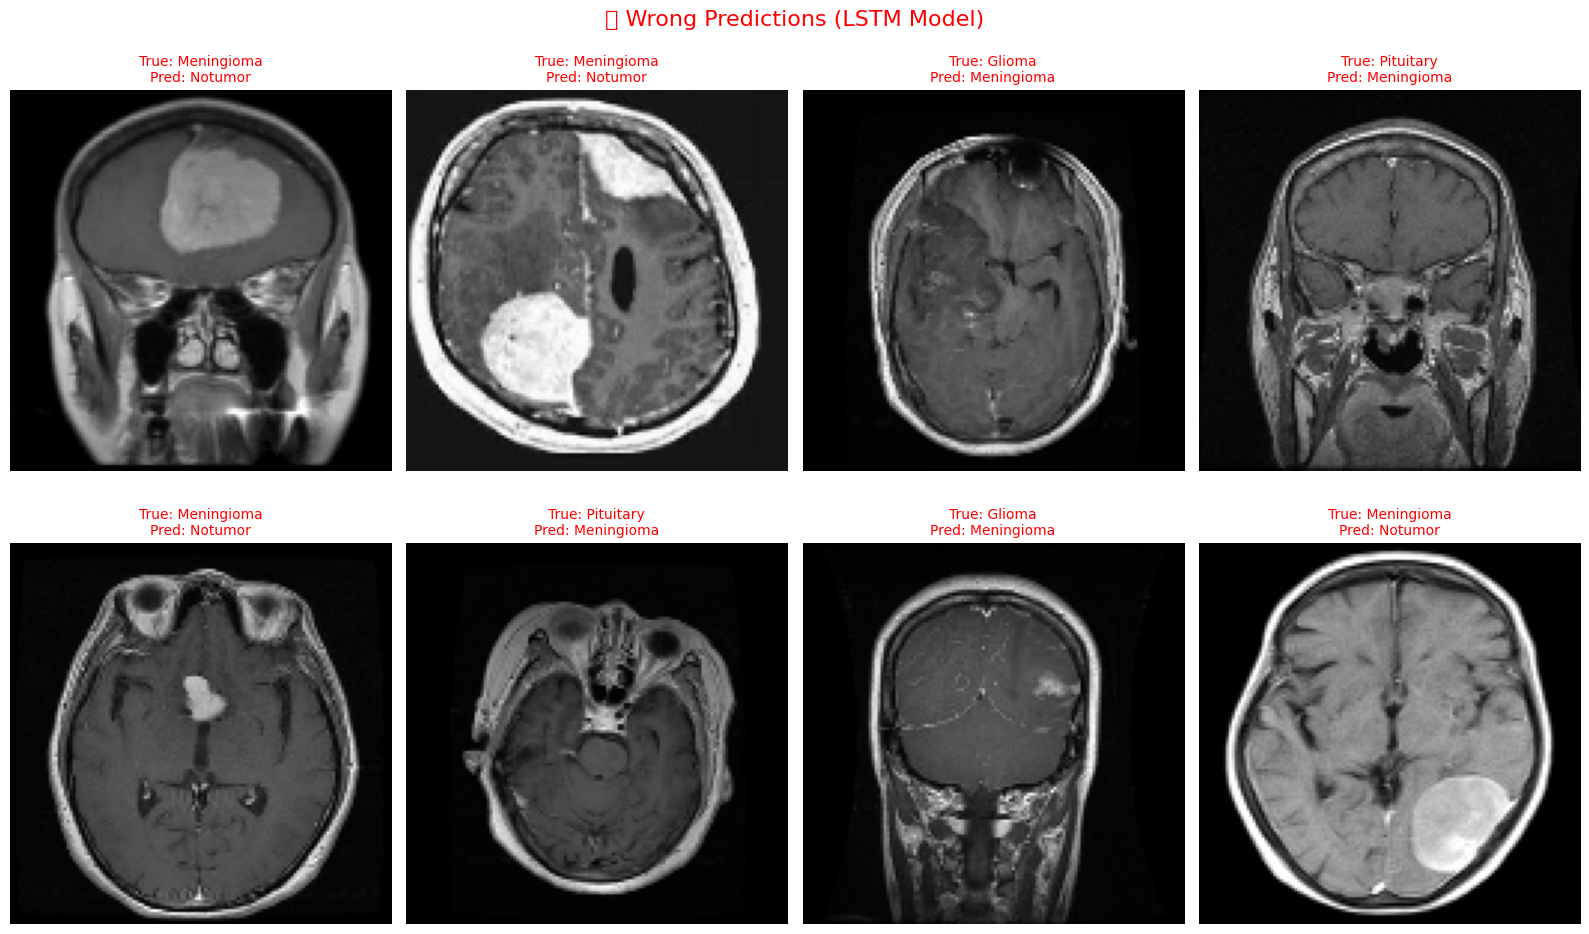

In [85]:
visualize_predictions(correct_lstm, "✅ Correct Predictions (LSTM Model)")
visualize_predictions(wrong_lstm, "❌ Wrong Predictions (LSTM Model)")
